#OTTIMIZZAZIONE DELLE PRESTAZIONI DI UNA RETE NEURALE PER IL SETTORE FOOD

##Autore: Rosa Santelia


### **Dettagli del Progetto:** GourmetAI Inc. ha richiesto lo sviluppo di un modello avanzato di classificazione di immagini di cibo utilizzando tecniche di deep learning. Il progetto si baserà sul dataset Food Classification, arricchito con tecniche di augmentation per migliorare la diversità e la qualità dei dati disponibili.

**Obiettivi e fasi implementative:**

- Sviluppo di strategie di Augmentation
- Preparazione del Dataset
- Selezione ed implementazione di Architetture di Rete e Transfer Learning
- Fine Tuning e Scelta degli Hyperparameters
- Validation e Regolarizzazione
- Test Finale


 **Dataset utilizzato:**
 https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip



---



1. Preparazione del Dataset

In [41]:
# Importazione di librerie e moduli (uso il Framework PyTorch)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix
import seaborn as sns
import json

In [42]:
# Imposto il Seed per garantire la riproducibilità

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [43]:
# Verifico di aver montato correttamente la GPU data la necessità di maggiore potenza computazionale

torch.cuda.is_available()

False

In [44]:
# Seleziono automaticamente il dispositivo su cui eseguire i tensori e i modelli PyTorch, preferendo la GPU (CUDA) se disponibile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
# Connetto Google Drive

from google.colab import drive
drive.mount('/gdrive')

# Imposto il path di recupero (modificabile in base alla propria struttura delle cartelle)

%cd /gdrive/My\ Drive/Colab Notebooks/dataset_food_classification

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/dataset_food_classification


In [10]:
# Definisco la classe Transform con relative funzioni di inizializzazione e chiamata (applico uno sviluppo modulare al fine di rendere riutilizzabile e maggiormente leggibile il codice§)

class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [11]:
# Effettuo la dichiarazione delle trasformazioni di base, inclusive di ridimensionamento, normalizzazione e conversione in tensore di PyTorch

transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])

In [12]:
# Carico i dataset, divisi in trainset, valset e testset

trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))

valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transform))

testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform))

In [ ]:
# Ispeziono il dataset per comprenderne le caratteristiche (lunghezza, features, formato)

trainset[0][0].shape

In [ ]:
len(trainset), len(valset), len(testset)

In [13]:
classes = trainset.classes
classes

['Baked Potato',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Sandwich',
 'Taco',
 'Taquito',
 'apple_pie',
 'cheesecake',
 'chicken_curry',
 'ice_cream',
 'omelette',
 'sushi']

In [ ]:
len(classes)

In [52]:
# Definisco una funzione per convertire un'immagine da tensore ad un formato visualizzabile

def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

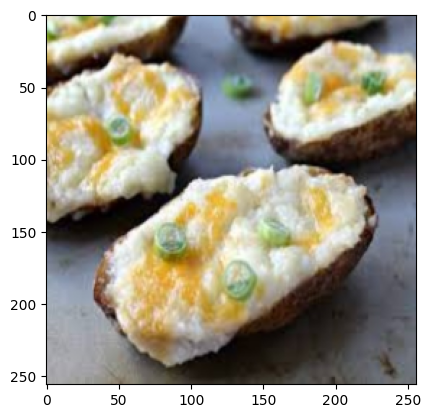

In [53]:
# Visualizzo la prima immagine del dataset

image = back_to_image(trainset[0][0])
plt.imshow(image)
plt.show()

In [15]:
# Inizializzo la variabile iteration a 0 e visualizzo le prime 3x5 immagini in un plot

iteration = 0

num_row = 3
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,3*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

Output hidden; open in https://colab.research.google.com to view.

Lo studio visivo delle immagini evidenzia la possibilità di effettuare Data Augmentations con tecniche di rotazione, flip orizzontale, trasposizione, color jitter leggero e zoom senza andare ad inficiare la rappresentatività del dato

2. Sviluppo delle Strategie di Augmentation

In [14]:
# Procedo ad applicare le tecniche di augmentations scelte per migliorare le performance ed evitare overfitting

augment = A.Compose([
            A.Resize(256, 256),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

            A.RandomRotate90(),
            A.RandomBrightnessContrast(p=0.1),
            A.HorizontalFlip(p=0.5),
            A.HueSaturationValue(p=0.1),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Transpose(),

            ToTensorV2(),
        ])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [15]:
# Carico il trainset "aumentato" ed ispeziono il risultato ottenuto con la Data Augmentation

trainset_aug = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(augment))

In [ ]:
iteration = 0

In [19]:
num_row = 3
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,3*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset_aug[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset_aug[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

Output hidden; open in https://colab.research.google.com to view.

In [20]:
trainset_aug[0][0].shape, len(trainset_aug)

(torch.Size([3, 256, 256]), 8960)

3. Selezione e Implementazione delle Architetture

In [16]:
# Creo i dataloader (per il trainloader tengo in considerazione direttamente il trainset_aug)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [22]:
# Definisco le funzioni per train, validation e test

In [17]:
# Parto con il definire la classe Early Stopping

class EarlyStopping:
    def __init__(self, save_path, patience=5, min_delta=0):

        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss, model):

        if self.min_val_loss is None:     #Prima epoca
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)

        elif (self.min_val_loss - validation_loss) > self.min_delta: #Epoca con miglioramento
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)
          self.counter = 0


        else:     #Nessun miglioramento
          self.counter +=1
          if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
      torch.save(model.state_dict(), self.save_path)

In [18]:
# Procedo con la definizione della funzione per il train che itera per le epoche (inserisco anche il parametro device per la GPU)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) #Parameters [128, 256, 256], [128, 14]

        optimizer.zero_grad()

        outputs = model(inputs) #Parameters [128, 14]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_data += len(inputs)

    return running_loss / processed_data

In [19]:
# Definisco poi la funzione per il test per l'iterazione durante le epoche

def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [20]:
# Creo una funzione generale per il train che considera la classe early stopping e definisce 50 epoche

def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=50, early_stopping=None):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses, test_losses, test_accuracies

In [21]:
# Infine vado a definire una funzione riutilizzabile per la Confusion Matrix per la valutazione

def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Greens')

In [28]:
# Creo il modello Baseline

In [47]:
# Definisco la funzione per la creazione della rete neurale convoluzionale (CNN) del modello base di partenza
# Ricreo un'architettura ispirata alla AlexNet proposta da Alex Krizhevsky, Ilya Sutskever e Geoffrey Hinton nel 2012 e che ho adattatato ad immagini 256x256

class AlexNet256(nn.Module):
    def __init__(self, num_classes=14):
        super(AlexNet256, self).__init__()

        # INPUT: [N, 3, 256, 256]

        # 5 LAYER CONVOLUZIONALI + MAX POOLING

        # Conv1: (11×11×3 + 1) × 96 = 34944
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)   # OUTPUT [N, 96, 62, 62]
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)                   # OUTPUT [N, 96, 30, 30]

        # Conv2: (5×5×96 + 1) × 256 = 614656
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)            # OUTPUT [N, 256, 30, 30]
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)                   # OUTPUT [N, 256, 14, 14]

        # Conv3: (3×3×256 + 1) × 384 = 885120
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)           # OUTPUT [N, 384, 14, 14]

        # Conv4: (3×3×384 + 1) × 384 = 1327488
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)           # OUTPUT [N, 384, 14, 14]

        # Conv5: (3×3×384 + 1) × 256 = 884992
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)           # OUTPUT [N, 256, 14, 14]
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)                   # OUTPUT [N, 256, 6, 6]

        # 3 LAYER FULLY CONNECTED + DROPOUT

        # FC1: (256×6×6 + 1) × 4096 = 37752832
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout1 = nn.Dropout(0.5)

        # FC2: (4096 + 1) × 4096 = 16781312
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        # FC3: (4096 + 1) × 14 = 4097 × 14 = 57358
        self.fc3 = nn.Linear(4096, 14)

        # TOTALE PARAMETRI -> 58.3 milioni

    def forward(self, x):

        # x: [N, 3, 256, 256]

        # Attivazione: ReLU

        x = F.relu(self.conv1(x))   # -> [N, 96, 62, 62]
        x = self.pool1(x)           # -> [N, 96, 30, 30]

        x = F.relu(self.conv2(x))   # -> [N, 256, 30, 30]
        x = self.pool2(x)           # -> [N, 256, 14, 14]

        x = F.relu(self.conv3(x))   # -> [N, 384, 14, 14]
        x = F.relu(self.conv4(x))   # -> [N, 384, 14, 14]
        x = F.relu(self.conv5(x))   # -> [N, 256, 14, 14]
        x = self.pool3(x)           # -> [N, 256, 6, 6]

        x = torch.flatten(x, 1)     # -> [N, 9216]
        x = self.dropout1(F.relu(self.fc1(x)))  # -> [N, 4096]
        x = self.dropout2(F.relu(self.fc2(x)))  # -> [N, 4096]
        x = self.fc3(x)             # -> [N, 14]

        return x


In [48]:
# Istanzio la rete baseline sul modello appena definito e ne visualizzo struttura e numero di parametri

baseline = AlexNet256().to(device)

In [31]:
summary(baseline, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 62, 62]          34,944
         MaxPool2d-2           [-1, 96, 30, 30]               0
            Conv2d-3          [-1, 256, 30, 30]         614,656
         MaxPool2d-4          [-1, 256, 14, 14]               0
            Conv2d-5          [-1, 384, 14, 14]         885,120
            Conv2d-6          [-1, 384, 14, 14]       1,327,488
            Conv2d-7          [-1, 256, 14, 14]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
            Linear-9                 [-1, 4096]      37,752,832
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
          Dropout-12                 [-1, 4096]               0
           Linear-13                   [-1, 14]          57,358
Total params: 58,338,702
Trainable para

In [56]:
# Imposto il percorso di salvataggio del modello

baseline_save_folder = "models/baseline/"
os.makedirs(baseline_save_folder, exist_ok = True)
baseline_save_file = os.path.join(baseline_save_folder,"model.pt")
baseline_save_log = os.path.join(baseline_save_folder,"log.json")

In [57]:
# Definisco la configurazione per il training della rete, sfruttando la funzione di Cross Entropy Loss trattandosi di un modello multiclasse ed Adam come optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)
early_stopping = EarlyStopping(baseline_save_file, patience=5, min_delta=0)
epochs = 50

In [34]:
# Effettuo il training di trainset_aug e valset

In [35]:
train_losses, test_losses, test_accuracies = train(
    baseline, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping
)

to_save_json = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies
}

with open(baseline_save_log, 'w') as f:
    json.dump(to_save_json, f)

Epoch 1/50, Train Loss: 0.0208, Validation Loss: 0.0205, Validation Accuracy: 0.1134
Epoch 2/50, Train Loss: 0.0197, Validation Loss: 0.0198, Validation Accuracy: 0.1237
Epoch 3/50, Train Loss: 0.0191, Validation Loss: 0.0192, Validation Accuracy: 0.1460
Epoch 4/50, Train Loss: 0.0185, Validation Loss: 0.0184, Validation Accuracy: 0.2134
Epoch 5/50, Train Loss: 0.0181, Validation Loss: 0.0182, Validation Accuracy: 0.2085
Epoch 6/50, Train Loss: 0.0180, Validation Loss: 0.0180, Validation Accuracy: 0.2259
Epoch 7/50, Train Loss: 0.0179, Validation Loss: 0.0180, Validation Accuracy: 0.2134
Epoch 8/50, Train Loss: 0.0178, Validation Loss: 0.0179, Validation Accuracy: 0.2384
Epoch 9/50, Train Loss: 0.0176, Validation Loss: 0.0177, Validation Accuracy: 0.2223
Epoch 10/50, Train Loss: 0.0174, Validation Loss: 0.0176, Validation Accuracy: 0.2317
Epoch 11/50, Train Loss: 0.0175, Validation Loss: 0.0175, Validation Accuracy: 0.2429
Epoch 12/50, Train Loss: 0.0173, Validation Loss: 0.0175, Valid

In [36]:
val_loss, val_accuracy = test_epoch(baseline, valloader, criterion, device)
print("Accuracy on val set: ", val_accuracy)

Accuracy on val set:  0.390625


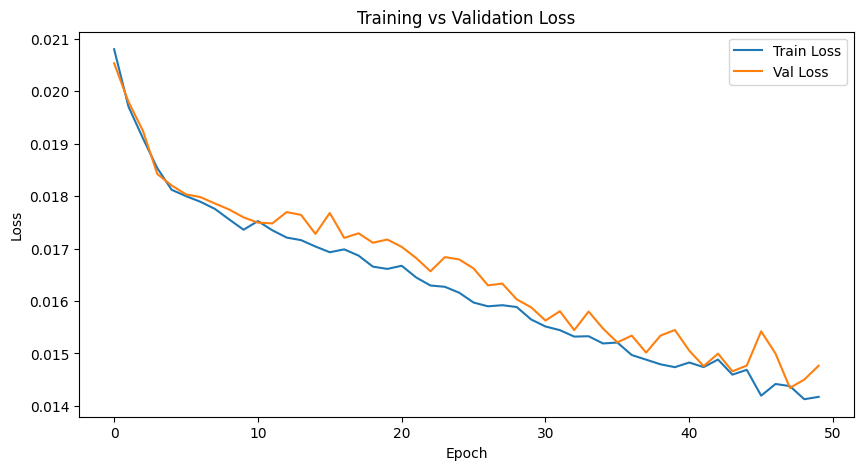

In [37]:
# Visualizzo graficamente l'andamento di trainloss e valloss

with open(baseline_save_log, "r") as f:
    baseline_save_log_data = json.load(f)
plt.figure(figsize=(10,5))
plt.plot(baseline_save_log_data['train_losses'], label='Train Loss')
plt.plot(baseline_save_log_data['test_losses'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


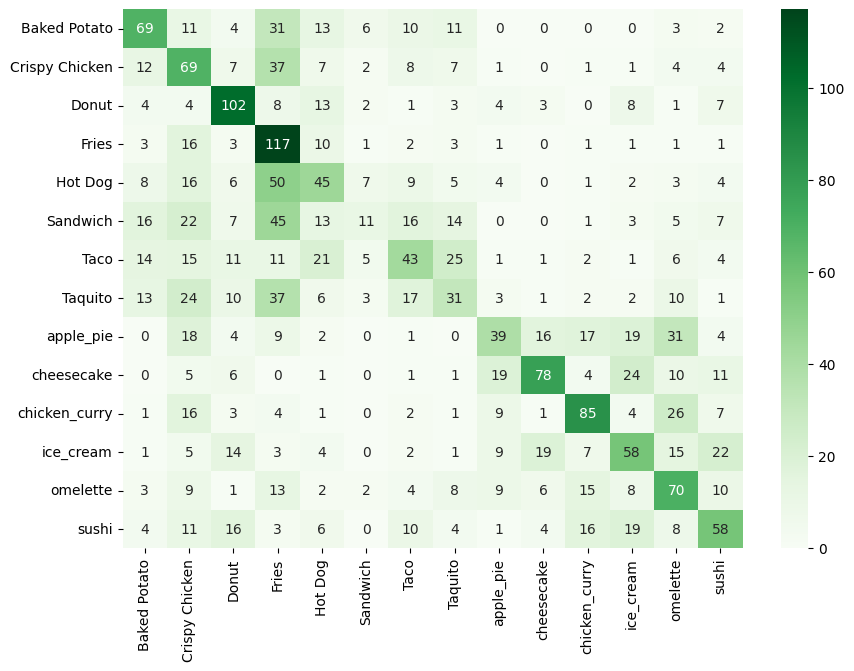

In [38]:
# Effettuo un ulteriore check dei risultati ottenuti con questo modello per il tramite della Confusion Matrix

plot_confusion_matrix(baseline, valloader, device)

4a. Fine Tuning e Scelta degli Hyperparameters

In [39]:
# Transfer Learning > ResNet18

In [50]:
# Parto da un modello preaddestrato ResNet18 presente nell'Hub di TorchVision
# Introdotto nel 2015 da un team di ricercatori Microsoft guidato da Kaiming He e vincitore della ILSVRC 2015 (ImageNet)

from torchvision import models
from torchvision.models import resnet18

resnet = resnet18(weights = models.ResNet18_Weights.DEFAULT).to(device)

In [41]:
# Documentazione: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [42]:
# Ne visualizzo la struttura

summary(resnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [51]:
# Effettuo il Freeze della backbone e sostituisco la parte fully connected con un classificatore su misura per il task

class ResNetClassifier(nn.Module):
    def __init__(self, resnet_backbone, num_classes, freeze_backbone=True):
        super().__init__()

        # Estraggo le features fino al penultimo blocco (escludendo fc e avgpool)
        self.features = nn.Sequential(*list(resnet_backbone.children())[:-2])  # [N, 512, 8, 8] per input 256x256
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))                            # [N, 512, 1, 1] -> gestisce dinamicamente la dimensione

        # Congelo i pesi con un Freeze
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        # Nuovo classificatore
        self.classifier = nn.Sequential(
            nn.Flatten(),                # [N, 512]
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)            # [N, 512, 8, 8]
        x = self.pooling(x)             # [N, 512, 1, 1]
        x = self.classifier(x)          # [N, 14]
        return x

In [52]:
# Applico il modello pretrainato

resnet = ResNetClassifier(resnet, num_classes=14, freeze_backbone=True).to(device)

In [45]:
# Visualizzo la struttura della rete adattatata

summary(resnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [47]:
# Imposto il percorso di salvataggio del modello

resnet_save_folder = "models/resnet/"
os.makedirs(resnet_save_folder, exist_ok = True)
resnet_save_file = os.path.join(resnet_save_folder,"model.pt")
resnet_save_log = os.path.join(resnet_save_folder,"log.json")

In [48]:
# Definisco la configurazione per il training della rete, sfruttando la funzione di Cross Entropy Loss trattandosi di un modello multiclasse ed Adam come optimizer
# Mantengo stesse epochs e larning  rate per preservare la confrontabilità con l'esperimento precedente

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
early_stopping = EarlyStopping(resnet_save_file, patience=5, min_delta=0)
epochs = 50

5a. Validation e Regolarizzazione

In [48]:
# Effettuo il training di trainset_aug e valset

train_losses, test_losses, test_accuracies = train(
    resnet, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping
)

to_save_json = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies
}

with open(resnet_save_log, 'w') as f:
    json.dump(to_save_json, f)

Epoch 1/50, Train Loss: 0.0117, Validation Loss: 0.0067, Validation Accuracy: 0.7464
Epoch 2/50, Train Loss: 0.0078, Validation Loss: 0.0057, Validation Accuracy: 0.7692
Epoch 3/50, Train Loss: 0.0071, Validation Loss: 0.0055, Validation Accuracy: 0.7830
Epoch 4/50, Train Loss: 0.0066, Validation Loss: 0.0053, Validation Accuracy: 0.7835
Epoch 5/50, Train Loss: 0.0063, Validation Loss: 0.0053, Validation Accuracy: 0.7817
Epoch 6/50, Train Loss: 0.0063, Validation Loss: 0.0052, Validation Accuracy: 0.7853
Epoch 7/50, Train Loss: 0.0061, Validation Loss: 0.0051, Validation Accuracy: 0.7871
Epoch 8/50, Train Loss: 0.0059, Validation Loss: 0.0050, Validation Accuracy: 0.7937
Epoch 9/50, Train Loss: 0.0059, Validation Loss: 0.0050, Validation Accuracy: 0.7964
Epoch 10/50, Train Loss: 0.0058, Validation Loss: 0.0049, Validation Accuracy: 0.7969
Epoch 11/50, Train Loss: 0.0057, Validation Loss: 0.0048, Validation Accuracy: 0.8009
Epoch 12/50, Train Loss: 0.0057, Validation Loss: 0.0049, Valid

In [49]:
val_loss, val_accuracy = test_epoch(resnet, valloader, criterion, device)

print("Accuracy on val set: ", val_accuracy)

Accuracy on val set:  0.8058035714285714


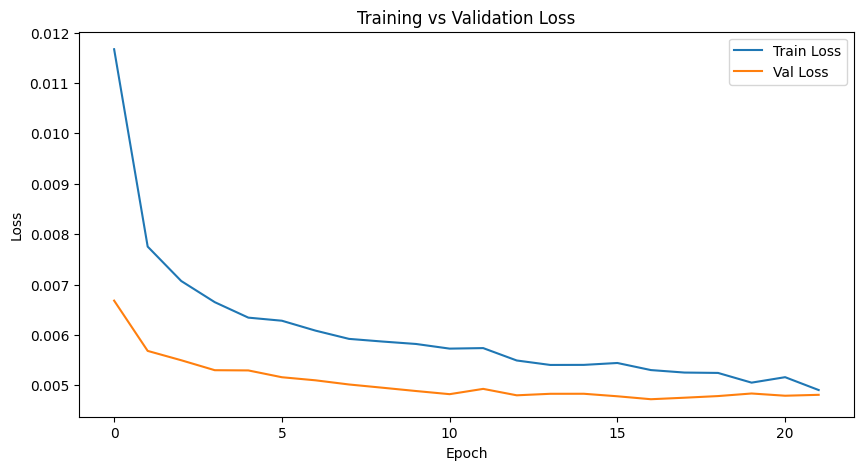

In [51]:
# Visualizzo graficamente l'andamento di trainloss e valloss

with open(resnet_save_log, "r") as f:
    resnet_save_log_data = json.load(f)
plt.figure(figsize=(10,5))
plt.plot(resnet_save_log_data['train_losses'], label='Train Loss')
plt.plot(resnet_save_log_data['test_losses'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


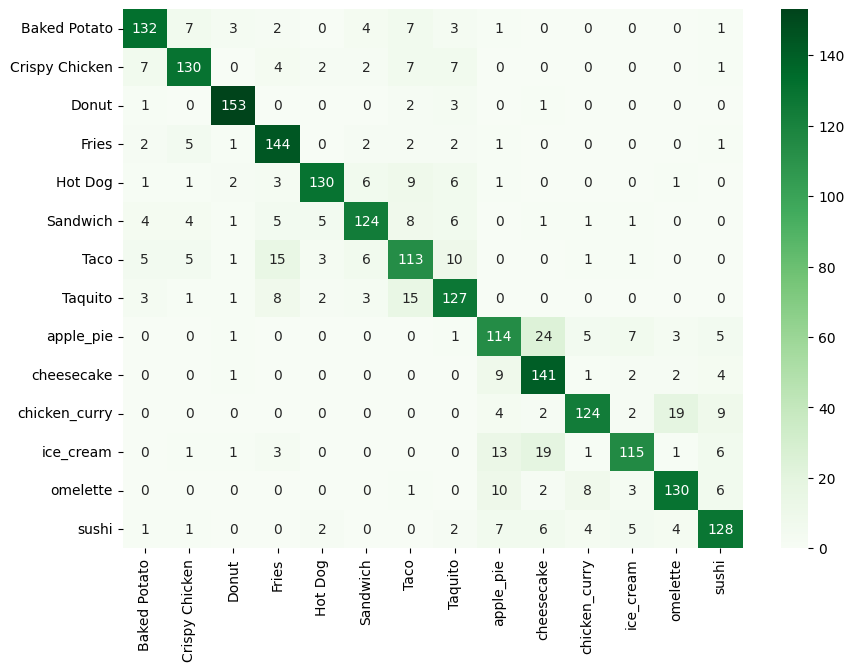

In [52]:
# Effettuo un ulteriore check dei risultati ottenuti con questo modello per il tramite della Confusion Matrix

plot_confusion_matrix(resnet, valloader, device)

4b. Fine Tuning e Scelta degli Hyperparameters

In [74]:
# Transfer Learning > EfficientNet-B0

In [23]:
# Procedo con i miei esperimenti e testo un differente modello preaddestrato dell'Hub di TorchVision, l'EfficientNet-B0
# Introdotto da Google Brain nel 2019, permette di ottenere un miglior bilanciamento tramite il Compound Scaling ed una migliore accuratezza (miglior rapporto performance/efficienza)

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

effb0 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


In [87]:
# Documentazione: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html

In [24]:
# Ne visualizzo la struttura

summary(effb0, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [25]:
# Frizzo tutti i parametri per la backbone

for param in effb0.parameters():
  param.requires_grad = False

# Lascio trainabile gli ultimi due blocchi

for param in effb0.features[-2:].parameters():
    param.requires_grad = True

In [26]:
# Aggiungo al modello un layer fully connected lineare che andrò ad ottimizzare/allenare

effb0.fc = nn.Linear(2048, 14).to(device)

In [27]:
# Visualizzo la struttura adattata della rete

summary(effb0, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [28]:
# Alleno e valido la rete riutilizzando le funzioni e classi prima definite

# Creo la cartella per il salvataggio dei checkpoints del modello

effb0_save_folder = "models/effb0/"
os.makedirs(effb0_save_folder, exist_ok=True)
effb0_save_file=os.path.join(effb0_save_folder,"model.pt")
effb0_save_log=os.path.join(effb0_save_folder, "log.json")

In [29]:
# Inizializzo la funzione Cross Entropy Loss trattandosi di un problema di classificazione multiclasse, definisco l'optimizer e setto gli altri hyperparameters

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effb0.parameters(), lr=0.001)
early_stopping=EarlyStopping(effb0_save_file, patience=5, min_delta=0)
epochs=50

5b. Validation e Regolarizzazione

In [30]:
# Effettuo il training vero e proprio

train_losses, test_losses, test_accuracies = train(
    effb0, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping
)

to_save_json = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies
}

with open(effb0_save_log, 'w') as f:
    json.dump(to_save_json, f)

Epoch 1/50, Train Loss: 0.0153, Validation Loss: 0.0052, Validation Accuracy: 0.8107
Epoch 2/50, Train Loss: 0.0058, Validation Loss: 0.0043, Validation Accuracy: 0.8406
Epoch 3/50, Train Loss: 0.0048, Validation Loss: 0.0040, Validation Accuracy: 0.8446
Epoch 4/50, Train Loss: 0.0042, Validation Loss: 0.0038, Validation Accuracy: 0.8536
Epoch 5/50, Train Loss: 0.0038, Validation Loss: 0.0037, Validation Accuracy: 0.8634
Epoch 6/50, Train Loss: 0.0034, Validation Loss: 0.0036, Validation Accuracy: 0.8674
Epoch 7/50, Train Loss: 0.0031, Validation Loss: 0.0037, Validation Accuracy: 0.8674
Epoch 8/50, Train Loss: 0.0029, Validation Loss: 0.0036, Validation Accuracy: 0.8696
Epoch 9/50, Train Loss: 0.0025, Validation Loss: 0.0038, Validation Accuracy: 0.8661
Epoch 10/50, Train Loss: 0.0025, Validation Loss: 0.0041, Validation Accuracy: 0.8647
Epoch 11/50, Train Loss: 0.0023, Validation Loss: 0.0038, Validation Accuracy: 0.8763
Epoch 12/50, Train Loss: 0.0021, Validation Loss: 0.0039, Valid

In [31]:
# Leggo e stampo l'accuracy

val_loss, val_accuracy = test_epoch(effb0, valloader, criterion, device)
print("Accuracy on val set: ", val_accuracy)

Accuracy on val set:  0.8705357142857143


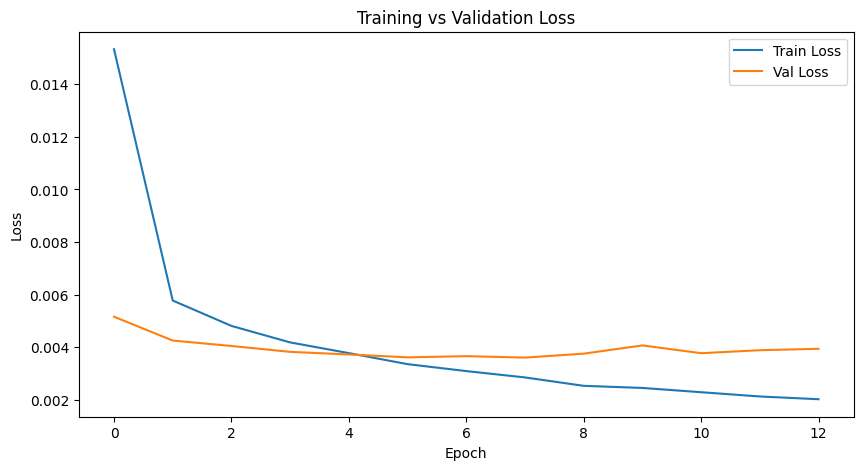

In [32]:
# Visualizzo graficamente l'andamento di trainloss e valloss

with open(effb0_save_log, "r") as f:
    effb0_save_log_data = json.load(f)
plt.figure(figsize=(10,5))
plt.plot(effb0_save_log_data['train_losses'], label='Train Loss')
plt.plot(effb0_save_log_data['test_losses'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

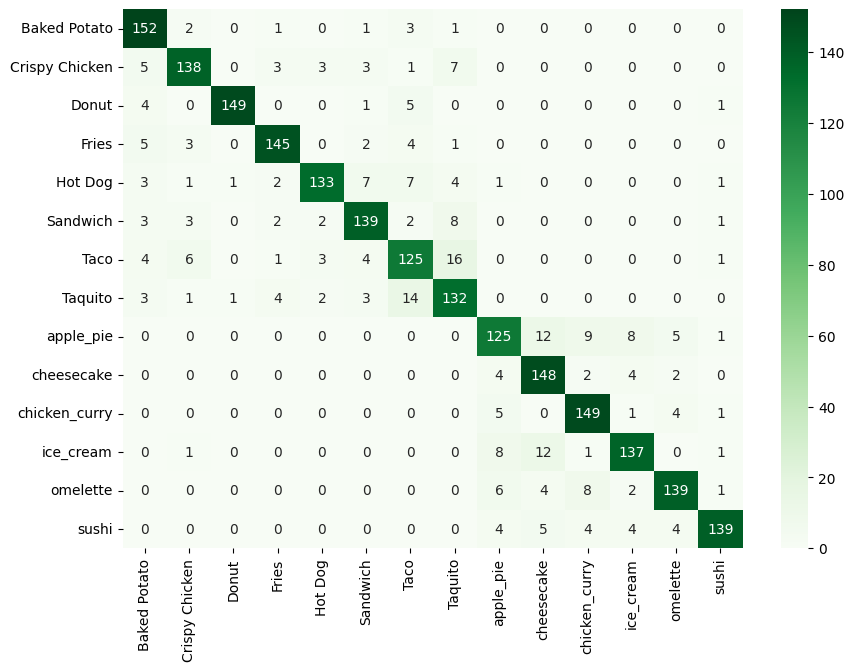

In [33]:
# Vado a verificare la Confusion Matrix

plot_confusion_matrix(effb0, valloader, device)

6. Test Finale

In [37]:
# Applico la funzione test_epoch prima definita sui vari modelli sperimentati

In [49]:
# Su modello Baseline

_ , accuracy_baseline = test_epoch(baseline, valloader, criterion, device)
accuracy_baseline

0.07142857142857142

In [53]:
# Su modello pretrainato ResNet18

_ , accuracy_resnet = test_epoch(resnet, valloader, criterion, device)
accuracy_resnet

0.06741071428571428

In [34]:
# Su modello pretrainato EfficientNet-B0

_ , accuracy_effb0 = test_epoch(effb0, valloader, criterion, device)
accuracy_effb0

0.8705357142857143

In [54]:
# Test finale su modello migliore

accuracies = {
    'baseline': accuracy_baseline,
    'resnet': accuracy_resnet,
    'effb0': accuracy_effb0
}

# Trovo il nome del modello con accuracy massima
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

# Seleziono il modello corrispondente
if best_model_name == 'baseline':
    best_model = baseline
elif best_model_name == 'resnet':
    best_model = resnet
else:
    best_model = effb0

# Chiamo il test_epoch con il modello migliore
_, accuracy_test = test_epoch(best_model, testloader, criterion, device)

In [58]:
# Stampo il risultato

print(f"Il modello di rete neurale convoluzionale migliore è {best_model_name} con accuracy sul test set di {best_accuracy:.4f}")

Il modello di rete neurale convoluzionale migliore è effb0 con accuracy sul test set di 0.8705




---



# **ANALISI DEI RISULTATI PER IL MODELLO MIGLIORE** ✅


- *Architettura:* EfficientNet-B0 (pre-addestrata su ImageNet e sottoposta a fine-tuning)

- *Obiettivo:* Classificazione multiclasse di diverse categorie di cibo

- *Metriche di Valutazione:* Accuracy, Training Loss, Validation Loss, Matrice di Confusione

- *Tecniche Utilizzate:* Early Stopping per prevenire l'overfitting




Il modello ha dimostrato prestazioni complessive molto buoni sul set di test:

Accuracy sul Test Set -> 0.8705 (87.05%)

Questo valore indica che il modello è in grado di classificare correttamente l'87.05% delle immagini nel set di test, un risultato molto positivo per il task in questione.

Il grafico "Training vs Validation Loss" offre insight cruciali sul processo di apprendimento del modello.
La loss sul set di addestramento (curva blu) mostra un decremento costante e significativo nel corso delle epoche, indicando che il modello sta apprendendo efficacemente a minimizzare l'errore sui dati su cui è stato addestrato.
La loss sul set di validazione (curva arancione) diminuisce anch'essa inizialmente, stabilizzandosi intorno a un valore di circa 0.0039−0.0041 dopo circa 7 epoche. Sebbene si noti un leggero aumento o fluttuazione nelle ultime epoche, questo suggerisce che il modello ha raggiunto una buona generalizzazione e che l'early stopping è stato efficace nel fermare l'addestramento prima che si verificasse un overfitting.
Sebbene esista un gap, con la Training Loss inferiore alla Validation Loss, il divario rimane gestibile e non indica un grave problema di overfitting, grazie anche all'applicazione dell'early stopping.

Il log dell'addestramento conferma l'andamento delle loss e fornisce l'evoluzione dell'accuracy di validazione. Il modello ha mostrato una rapida convergenza, con la Validation Accuracy che è passata da 0.8107 a 0.8634 nelle prime 6 epoche. La Validation Accuracy ha raggiunto un picco di 0.8763 all'epoca 11, stabilizzandosi successivamente intorno a valori coerenti con l'accuracy del test set (0.8705−0.8714).
Il processo di early stopping ha interrotto l'addestramento all'epoca 13. Questo è stato cruciale per evitare l'overfitting, assicurando che il modello mantenesse la sua capacità di generalizzazione sui dati non visti.

La matrice di confusione fornisce una granularità elevata sulle prestazioni del modello per ciascuna classe, evidenziando le classificazioni corrette e le confusioni.
Il modello dimostra un'eccellente capacità di classificazione per la maggior parte delle categorie, con un elevato numero di True Positives (valori sulla diagonale principale). Esempi includono "Baked Potato" (152), "Crispy Chicken" (138), "Donut" (149), "Sandwich" (139), "Cheesecake" (148), "Chicken Curry" (149), "Omelette" (139) e "Sushi" (139). Questi risultati indicano che il modello ha appreso caratteristiche distintive per queste classi.

Aree di Potenziale Miglioramento:
- Taco vs. Taquito: si osserva una reciproca confusione significativa. "Taco" viene erroneamente classificato come "Taquito" in 16 casi, e "Taquito" come "Taco" in 14 casi. Questo è comprensibile data la somiglianza visiva e strutturale tra questi due alimenti
- Dessert (Apple Pie, Cheesecake, Ice Cream): nonostante prestazioni generalmente buone, vi sono alcune confusioni incrociate. Ad esempio, "Apple Pie" è confuso con "Cheesecake" (12) e "Ice Cream" (8); "Ice Cream" è confuso con "Apple Pie" (8) e "Cheesecake" (12). Ciò suggerisce che il modello fatica a distinguere le sottili differenze tra questi dolci in alcuni contesti
- Fries: Sebbene ben classificato, mostra alcune confusioni con "Baked Potato" (3), "Crispy Chicken" (3) e "Taco" (4)
- Hot Dog: Confusione con "Taco" (7) e "Taquito" (4), suggerendo somiglianze visive percepite dal modello.

**Conclusioni:**

Il modello pretrainato basato su EfficientNet-B0 ha dimostrato di essere un classificatore di immagini estremamente efficace, raggiungendo un'ottima accuratezza del 87.05% sul set di test. Le curve di loss indicano un addestramento stabile e una buona generalizzazione, supportata dall'efficace applicazione dell'early stopping.

Per migliorare ulteriormente le prestazioni e affrontare le specifiche aree di debolezza identificate, si potrebbe valutare:

- Ulteriore arricchimento del dataset per le sole classi confuse tramite techiche di data augmentation mirate per taco, taquito e dessert

- Esplorazione di architetture differenti, considerando il fine-tuning di una versione più grande di EfficientNet (EfficientNet-B1 o B2), tenendo conto però dell'aumento delle risorse computazionali e del rischio di overfitting

- Ottimizzazione degli Iperparametri (ad esempio learning rate o batch size minori).
